# Подготовка сессии

In [1]:
import random
random.seed(88)
import torch
torch.manual_seed(88)

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")
import os
import json


## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [3]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image
    @staticmethod
    def read_mask(path: str) -> np.ndarray:
        mask = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
        mask = np.array(mask / 255, dtype=np.float32)
        return mask

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        mask_path = image_path.replace("images", "masks")

        image = self.read_image(image_path)

        mask = self.read_mask(mask_path)

        sample = {'image': image,
                  'mask': mask}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)



class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)


In [4]:
# Задаем преобразование изображений
size = 640
train_list = [
              A.PadIfNeeded(size, size, position = 'top_left'),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [
              A.PadIfNeeded(size, size, position = 'top_left'),
              ToTensorV2(transpose_mask=True)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}


In [5]:
# Инициализируем датасет
dataset = EyeDataset("content_train/aug_images/")

In [7]:
len(dataset)

8704

In [8]:
# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=88)

In [9]:
print(f"Разбиение на train/test : {len(train_indices)}/{len(test_indices)}")

Разбиение на train/test : 6963/1741


In [10]:
# Разбиваем объект датасета на тренировочный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, 6,
                                           num_workers=3,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 6,
                                           num_workers=3,
                                   shuffle=True, drop_last=True)

# Класс тренировщика модели

In [13]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer  
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """

        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):
            try:
                batch = next(train_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader, num_epochs: int,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
          # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]
                
                summary[metric_name].append(metric_value)
        
        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1
            print(self.epoch_number)
            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)
            print(train_metrics)
            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    print('test = ', test_metrics)
                    save_metrics(test_metrics, postfix='_test')
                    torch.save(model, 'vgg16_'+str(self.epoch_number)+'.pt')
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}
        
        return summary


In [14]:
# Метрики

In [15]:
# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b*b

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)
        fn = torch.sum((targets* (1 - predictions)))
        tp=numerator

        recall = tp / (tp + fn + self.epsilon)

        return recall
    
# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b*b

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        fp = torch.sum((1 - targets) * predictions)          
        tp = torch.sum(predictions * targets)   
        precision = tp / (tp + fp + self.epsilon)
        return precision

def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    accuracy = Accuracy()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_acc(pred, target):
        return accuracy(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('dice', exp_dice),
            ('accuracy', exp_acc),
            ('recall', exp_recall),
            ]

## Модель

In [16]:
torch.cuda.empty_cache()

In [19]:
# Подргружаем модель и задаём функцию потерь
model = smp.Unet('vgg16', activation='logsoftmax', classes=2).cuda()

def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])
    return exp_dice

criterion = make_criterion()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), 0.000099)

In [22]:
# Обучаем модель, сохраняем модель после 10 эпохи под именем vgg16_10.pt
# ссылка на модель на гугл диске https://drive.google.com/file/d/1pYYbx-ANsLybjYe1uv2L8R8cNTiZveNY/view?usp=sharing
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())
summary = trainer.fit(train_loader, 20, val_loader=valid_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

1
{'loss': 0.5024599168835016, 'dice': 0.49754008379681935, 'accuracy': 0.45690430978551816, 'recall': 0.6922321996504942}
test =  {'loss': 0.4267154584670889, 'dice': 0.5732845428736819, 'accuracy': 0.47322499968099535, 'recall': 0.7791138705324305}


  5%|▌         | 1/20 [21:30<6:48:31, 1290.09s/it]

2
{'loss': 0.3930101234851212, 'dice': 0.6069898809128877, 'accuracy': 0.5988318349280579, 'recall': 0.6590777963072595}
test =  {'loss': 0.40460890387666637, 'dice': 0.5953911006450653, 'accuracy': 0.55574835474635, 'recall': 0.6841120209287981}


 10%|█         | 2/20 [42:19<6:23:20, 1277.83s/it]

3
{'loss': 0.38471356383685407, 'dice': 0.6152864402931402, 'accuracy': 0.6105548408606198, 'recall': 0.6647014362275458}
test =  {'loss': 0.4425925848812893, 'dice': 0.5574074143612334, 'accuracy': 0.7502432217026643, 'recall': 0.4712573479955483}


 15%|█▌        | 3/20 [1:03:13<6:00:00, 1270.62s/it]

4
{'loss': 0.37730359851286327, 'dice': 0.622696404074961, 'accuracy': 0.6194838419903602, 'recall': 0.6661216849652639}
test =  {'loss': 0.3759446485289212, 'dice': 0.6240553583821346, 'accuracy': 0.6702012451558278, 'recall': 0.6200854644693178}


 20%|██        | 4/20 [1:24:16<5:38:13, 1268.34s/it]

5
{'loss': 0.37120194887292796, 'dice': 0.6287980562381226, 'accuracy': 0.6249027156201009, 'recall': 0.6744141500214828}
test =  {'loss': 0.3724951296017088, 'dice': 0.627504880063413, 'accuracy': 0.5878463027701746, 'recall': 0.7157953899793084}


 25%|██▌       | 5/20 [1:44:59<5:15:13, 1260.88s/it]

6
{'loss': 0.3735004481570474, 'dice': 0.6264995598737002, 'accuracy': 0.6225086808389364, 'recall': 0.6697771802529865}
test =  {'loss': 0.399798491494409, 'dice': 0.6002015217421707, 'accuracy': 0.6794331355805266, 'recall': 0.5714681298431084}


 30%|███       | 6/20 [2:05:32<4:52:13, 1252.42s/it]

7
{'loss': 0.37179910314494163, 'dice': 0.6282009069618875, 'accuracy': 0.6242010544946235, 'recall': 0.6714991032201308}
test =  {'loss': 0.36696708428448643, 'dice': 0.633032906205586, 'accuracy': 0.623831404340057, 'recall': 0.6707691487055791}


 35%|███▌      | 7/20 [2:27:06<4:34:03, 1264.92s/it]

8
{'loss': 0.36484135589722927, 'dice': 0.6351586403419748, 'accuracy': 0.6285978108140539, 'recall': 0.678464158300884}
test =  {'loss': 0.3738028283776908, 'dice': 0.6261972046746263, 'accuracy': 0.6772785811652912, 'recall': 0.6202632068046208}


 40%|████      | 8/20 [2:47:56<4:12:06, 1260.53s/it]

9
{'loss': 0.36088330000638963, 'dice': 0.6391166997814457, 'accuracy': 0.6330688886080819, 'recall': 0.6813069562192829}
test =  {'loss': 0.3776394546031952, 'dice': 0.6223605371444976, 'accuracy': 0.6593529262988623, 'recall': 0.6203553377361559}


 45%|████▌     | 9/20 [3:09:10<3:51:50, 1264.59s/it]

10
{'loss': 0.35932400725011165, 'dice': 0.6406759863625469, 'accuracy': 0.6356970626185635, 'recall': 0.6847340173855982}
test =  {'loss': 0.38324673340238374, 'dice': 0.6167532200346935, 'accuracy': 0.6660153891051989, 'recall': 0.606771509894756}


 50%|█████     | 10/20 [3:29:46<3:29:20, 1256.01s/it]

11
{'loss': 0.3526372858162584, 'dice': 0.6473626883699493, 'accuracy': 0.6409932645146525, 'recall': 0.6901191606961294}
test =  {'loss': 0.3777719419578026, 'dice': 0.6222280355030172, 'accuracy': 0.6747397565917144, 'recall': 0.6070931259890591}


 55%|█████▌    | 11/20 [3:50:47<3:08:37, 1257.45s/it]

12
{'loss': 0.35469043054457366, 'dice': 0.6453095421922848, 'accuracy': 0.6408815684228656, 'recall': 0.6874050020490253}
test =  {'loss': 0.3594969772059342, 'dice': 0.6405029794228779, 'accuracy': 0.6305911034667776, 'recall': 0.6804896240342785}


 60%|██████    | 12/20 [4:12:02<2:48:21, 1262.73s/it]

13
{'loss': 0.34485349624321376, 'dice': 0.6551464766181355, 'accuracy': 0.6500951825005364, 'recall': 0.6944933135631437}
test =  {'loss': 0.359835310434473, 'dice': 0.6401646963481246, 'accuracy': 0.660000292956829, 'recall': 0.6559319041412452}


 65%|██████▌   | 13/20 [4:32:59<2:27:06, 1260.95s/it]

14
{'loss': 0.35449018683926814, 'dice': 0.6455098063901106, 'accuracy': 0.6402463360873949, 'recall': 0.6898939350434271}
test =  {'loss': 0.35779585735551245, 'dice': 0.6422041487088023, 'accuracy': 0.6169428938697192, 'recall': 0.7019989925469311}


 70%|███████   | 14/20 [4:54:29<2:06:58, 1269.74s/it]

15
{'loss': 0.3417534639609271, 'dice': 0.6582465152919506, 'accuracy': 0.6543163972815578, 'recall': 0.6956065195734595}
test =  {'loss': 0.36368775655483376, 'dice': 0.6363122224337501, 'accuracy': 0.7105844714085708, 'recall': 0.6035520375058677}


 75%|███████▌  | 15/20 [5:15:42<1:45:53, 1270.69s/it]

16
{'loss': 0.355408348348634, 'dice': 0.6445916361654336, 'accuracy': 0.6421500516797433, 'recall': 0.6850606054368449}
test =  {'loss': 0.3657897030485087, 'dice': 0.6342102386724321, 'accuracy': 0.5999979847022995, 'recall': 0.7089953301493406}


 80%|████████  | 16/20 [5:37:29<1:25:26, 1281.58s/it]

17
{'loss': 0.3364112213767808, 'dice': 0.6635887411894492, 'accuracy': 0.6587256353455769, 'recall': 0.7032413549899554}
test =  {'loss': 0.3563769807075632, 'dice': 0.6436229721474284, 'accuracy': 0.6560825568951582, 'recall': 0.6667546765655971}


 85%|████████▌ | 17/20 [5:58:53<1:04:07, 1282.44s/it]

18
{'loss': 0.3276928684834776, 'dice': 0.6723070903432178, 'accuracy': 0.6663035083904364, 'recall': 0.7106821341641743}
test =  {'loss': 0.3652565257302646, 'dice': 0.6347434113679259, 'accuracy': 0.5880643113851126, 'recall': 0.7305386750361176}


 90%|█████████ | 18/20 [6:20:24<42:49, 1284.76s/it]  

19
{'loss': 0.326830253364711, 'dice': 0.6731697029336655, 'accuracy': 0.6696883793989439, 'recall': 0.7090482300070866}
test =  {'loss': 0.34653552976147883, 'dice': 0.6534644119698426, 'accuracy': 0.6555805455764819, 'recall': 0.6844866027092111}


 95%|█████████▌| 19/20 [6:41:45<21:23, 1283.85s/it]

20
{'loss': 0.33059231741675016, 'dice': 0.6694076425809414, 'accuracy': 0.6657528061854291, 'recall': 0.7050722073718269}
test =  {'loss': 0.36490305888241736, 'dice': 0.6350969071392567, 'accuracy': 0.6946096874998053, 'recall': 0.6127070221081163}


100%|██████████| 20/20 [7:03:10<00:00, 1269.55s/it]


## Посмотрим метрики обученной модели на валидационном датасете

In [23]:
summary

{'loss_train': array([0.50245992, 0.39301012, 0.38471356, 0.3773036 , 0.37120195,
        0.37350045, 0.3717991 , 0.36484136, 0.3608833 , 0.35932401,
        0.35263729, 0.35469043, 0.3448535 , 0.35449019, 0.34175346,
        0.35540835, 0.33641122, 0.32769287, 0.32683025, 0.33059232]),
 'dice_train': array([0.49754008, 0.60698988, 0.61528644, 0.6226964 , 0.62879806,
        0.62649956, 0.62820091, 0.63515864, 0.6391167 , 0.64067599,
        0.64736269, 0.64530954, 0.65514648, 0.64550981, 0.65824652,
        0.64459164, 0.66358874, 0.67230709, 0.6731697 , 0.66940764]),
 'accuracy_train': array([0.45690431, 0.59883183, 0.61055484, 0.61948384, 0.62490272,
        0.62250868, 0.62420105, 0.62859781, 0.63306889, 0.63569706,
        0.64099326, 0.64088157, 0.65009518, 0.64024634, 0.6543164 ,
        0.64215005, 0.65872564, 0.66630351, 0.66968838, 0.66575281]),
 'recall_train': array([0.6922322 , 0.6590778 , 0.66470144, 0.66612168, 0.67441415,
        0.66977718, 0.6714991 , 0.67846416, 0.68

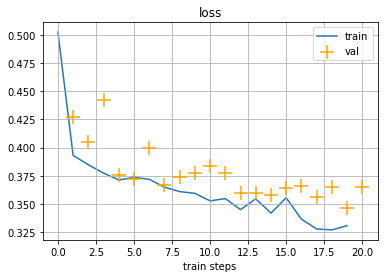

In [24]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

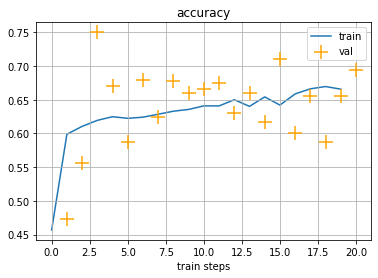

In [25]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

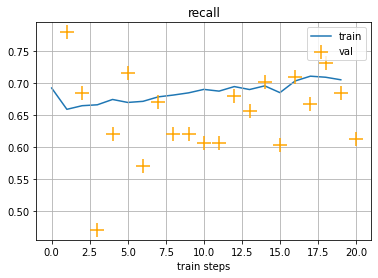

In [26]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [17]:
# Дообучим модель, сохраненную после 10 эпохи
model = torch.load('vgg16_10.pt').cuda()

In [18]:
def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

criterion = make_criterion()

In [82]:
# Изменим скорость обучения
optimizer = torch.optim.Adam(model.parameters(), 0.000039)

In [83]:
# На тестовых данных лучший результат был получен после 1 эпохи
# Эта модель сохранена под названием vgg16_1.pt, ссылка на модель:
# https://drive.google.com/file/d/1wbMDlZbjcPHVpjxMOmLNlAvED-bLmFyF/view?usp=sharing
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())
summary = trainer.fit(train_loader, 20, val_loader=valid_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

1
{'loss': 0.34512100579409766, 'dice': 0.6548789664491601, 'accuracy': 0.6471153574049562, 'recall': 0.6970664127968242}
test =  {'loss': 0.3632208941311672, 'dice': 0.6367791047020814, 'accuracy': 0.6748688229754846, 'recall': 0.6329570581771781}


  5%|▌         | 1/20 [21:03<6:40:07, 1263.54s/it]

2
{'loss': 0.34316315835919875, 'dice': 0.6568368124276982, 'accuracy': 0.6523974713934921, 'recall': 0.695531861619077}
test =  {'loss': 0.35196357903809383, 'dice': 0.6480364061635117, 'accuracy': 0.6539590042726747, 'recall': 0.6687797015083248}


 10%|█         | 2/20 [41:34<6:16:09, 1253.88s/it]

3
{'loss': 0.3345173774094417, 'dice': 0.6654826010568936, 'accuracy': 0.659223337057085, 'recall': 0.7037520153237391}
test =  {'loss': 0.362063815059333, 'dice': 0.6379361833619467, 'accuracy': 0.6368967761856136, 'recall': 0.6781401882624497}


 15%|█▌        | 3/20 [1:01:54<5:52:20, 1243.53s/it]

4


KeyboardInterrupt: 

# ПРЕДСКАЗАНИЕ НА ТЕСТЕ

In [13]:
# Функция создает директорию, если ее не существует по указанному пути
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [14]:
test_path = 'content/test/parts_images/'
test_parts_masks = 'content/test/parts_masks/'
test_masks = 'content/test/masks/'
binary_test_masks = 'content/test/masks_binary/'
create_dir(test_parts_masks)
create_dir(test_masks)
create_dir(binary_test_masks)

In [34]:
model = torch.load('vgg16_1.pt').cuda()

In [35]:
class EyeDataset_test(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image


    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]
        
        image = self.read_image(image_path)

        sample = {'image': image,
                 'path':image_path }
        
        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)


In [36]:
# определяем путь к тестовому датасету и загружаем данные
dataset_test = EyeDataset_test(test_path)
test_dataset = DatasetPart(dataset_test, range(len(dataset_test)), transform=transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, 1,
                                   num_workers=2,
                                   shuffle=False, drop_last=True)

In [37]:
len(dataset_test)

2408

In [5]:
# получаем предсказанные маски
for i, sample in zip(range(len(test_dataset)), test_dataset):
    image = sample['image'].to("cuda")
    prediction = model.eval()(image.unsqueeze(dim=0))
    torch.cuda.empty_cache()
    image = (image.cpu() * 0).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.95).cpu()
    image_with_mask = draw_segmentation_masks(image, pred_ask, alpha=1)
    del image
    del pred_ask
    del prediction
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    img = image_with_mask[0:616, 0:406]
    path = str(test_parts_masks) + str(sample['path'].split('/')[-1:])[2:-2]    
    cv2.imwrite(path, img)
    torch.cuda.empty_cache()

In [17]:
# Функция объединяет 8 частей изображения в одно
h_parts=4
v_parts=2
height=1232 
width=1624
def join_images(main_path, parts_path, new_path):
    for file in sorted(os.listdir(main_path)):
        if file[-3:] == 'png':
            path_read = parts_path + file[:-4]
            path_save = new_path + file
            im_big = np.zeros((1232,1624,3))
            for i in range(0, v_parts):
                for j in range(0, h_parts):
                    v_from = int(i*(height/v_parts))
                    v_to = int((i+1)*(height/v_parts))
                    h_from = int(j*(width/h_parts))
                    h_to = int((j+1)*(width/h_parts))
                
                    im1 = cv2.imread(path_read+'_' + str((i*4)+(j+1)) + '.png', cv2.IMREAD_COLOR)
                    im1 = np.array(im1)
                    im_big[v_from:v_to, h_from:h_to, :] = im1[0:618, 0:406, :]
            cv2.imwrite(path_save, im_big)

In [19]:
join_images('content/test/eyes/', test_parts_masks, test_masks)

##### Преобразуем все маски в числа от 0 до 255

In [20]:
for file in os.listdir(test_masks):
    img = cv2.imread(test_masks+file, cv2.IMREAD_GRAYSCALE)
    thresh = 80
    img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite(binary_test_masks+file, img)